In [1]:
import torch
from typing import Tuple

############
# PART 1.1 #
############

def sgd_factorise_ad(A:torch.Tensor, rank:int, num_epochs=1000, lr=0.01): # -> Tuple[torch.Tensor, torch.Tensor]
    m = A.shape[0]
    n = A.shape[1]
    U = torch.rand(m,rank, requires_grad=True)
    V = torch.rand(n,rank, requires_grad=True)
    #print(U)
    #print(V)
    for epoch in range(num_epochs):
        '''for r in range(m):
            for c in range(n):
                e = A[r][c] - torch.dot(U[r],V[c])
                U[r] += lr*e*V[c]
                V[c] += lr*e*U[r]'''
        U.grad = None
        V.grad = None
        e = torch.nn.functional.mse_loss(torch.mm(U,V.T), A, reduction="sum")#**2
        e.backward()
        z1 = U - lr*U.grad
        z2 = V - lr*V.grad
        U.data = z1
        V.data = z2
        #print(U)
        
    return (U,V)


A = torch.tensor([[0.3374, 0.6005, 0.1735],
                  [3.3359, 0.0492, 1.8374],
                  [2.9407, 0.5301, 2.2620]])

U,V = sgd_factorise_ad(A,2)
print("U:\n%s" % U)
print("V:\n%s" % V)
print("U*V^T:\n%s" % torch.mm(U,V.T))

print("MSE loss:")
print(torch.nn.functional.mse_loss(torch.mm(U,V.T), A, reduction="sum"))

U:
tensor([[ 0.7865, -0.0359],
        [ 0.1739,  1.7598],
        [ 1.0573,  1.4621]], requires_grad=True)
V:
tensor([[ 0.3684,  1.8118],
        [ 0.6619, -0.0701],
        [ 0.5047,  1.0723]], requires_grad=True)
U*V^T:
tensor([[ 0.2248,  0.5231,  0.3585],
        [ 3.2523, -0.0082,  1.9747],
        [ 3.0385,  0.5973,  2.1014]], grad_fn=<MmBackward>)
MSE loss:
tensor(0.1219, grad_fn=<MseLossBackward>)


In [2]:
############
# PART 1.2 #
############


import pandas as pd
import numpy as np
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
                 header=None)
data = torch.tensor(df.iloc[:,[0,1,2,3]].values,dtype=torch.float)
data = data - data.mean(dim = 0)

U,V = sgd_factorise_ad(data,2)
#print("U:\n%s" % U)
#print("V:\n%s" % V)
#print("U*V^T:\n%s" % torch.mm(U,V.T))

print("MSE loss:")
print(torch.nn.functional.mse_loss(torch.mm(U,V.T), data, reduction="sum"))

U2,S2,V2 = torch.svd(data)
print(U2.shape)
print(S2.shape)
print(V2.shape)
S3 = torch.tensor([[S2[0],0,0,0],
                   [0,S2[1],0,0],
                   [0,0,0,0],
                   [0,0,0,0]])
data2 = torch.mm(U2,torch.mm(S3,V2.T))
print("\nSVD reconstruction with only 2 singular values:")
print("MSE loss:",float(torch.nn.functional.mse_loss(data2, data, reduction="sum")))



MSE loss:
tensor(15.2289, grad_fn=<MseLossBackward>)
torch.Size([150, 4])
torch.Size([4])
torch.Size([4, 4])

SVD reconstruction with only 2 singular values:
MSE loss: 15.22883129119873


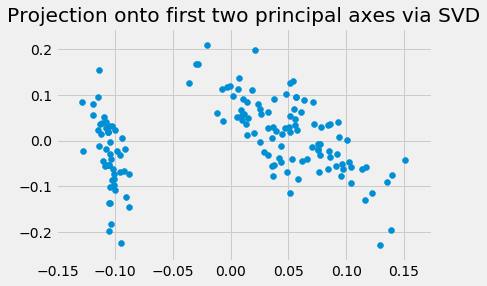

Text(0.5, 1.0, 'Data from $\\mathbf{\\widehat{U}}$')

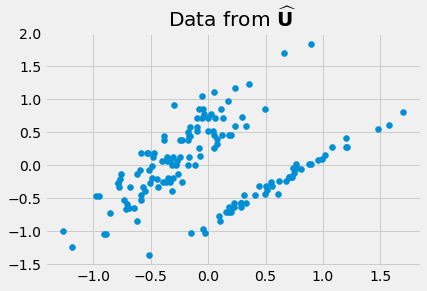

In [3]:
############
# PART 1.3 #
############

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plotdata = torch.mm(U2,S3)
#plt.scatter(plotdata[:,0],plotdata[:,1])
plt.scatter(U2[:,0],U2[:,1])
plt.title("Projection onto first two principal axes via SVD")
plt.show()

x,y = [],[]
for i in U:
    x.append(float(i[0]))
    y.append(float(i[1]))
plt.scatter(x,y)
plt.title("Data from $\mathbf{\widehat{U}}$")

tensor(0.6145, grad_fn=<NllLossBackward>)
tensor(0.5560, grad_fn=<NllLossBackward>)


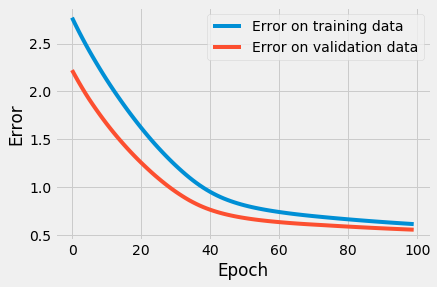

In [26]:
############
# PART 2.1 #
############

import pandas as pd
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
                 header=None)
df = df.sample(frac=1) # shuffle

# add label indices column
mapping = {k: v for v, k in enumerate(df[4].unique())}
df[5] = df[4].map(mapping)

# normalise data
alldata = torch.tensor(df.iloc[:, [0,1,2,3]].values,dtype=torch.float)
alldata = (alldata-alldata.mean(dim=0))/alldata.var(dim=0)

# create datasets
targets_tr = torch.tensor(df.iloc[:100,5].values, dtype=torch.long)
targets_va = torch.tensor(df.iloc[100:,5].values, dtype=torch.long)
data_tr = alldata[:100]
data_va = alldata[100:]

#==========================

m = data_tr.shape[0]
n = data_tr.shape[1]

W1 = torch.randn(4,12, requires_grad=True)
W2 = torch.randn(12,3, requires_grad=True)
b1 = torch.tensor(0.0, requires_grad=True)
b2 = torch.tensor(0.0, requires_grad=True)

num_epochs = 100
lr = 0.01

e_train = []
e_valid = []
for epoch in range(num_epochs):
    W1.grad = None
    W2.grad = None
    b1.grad = None
    b2.grad = None
    logits = torch.relu(data_tr@W1 + b1) @ W2 + b2
    e = torch.nn.functional.cross_entropy(logits,targets_tr)
    e_train.append(e)
    e_valid.append(torch.nn.functional.cross_entropy(torch.relu(data_va@W1 + b1) @ W2 + b2,
                                                     targets_va))
    e.backward()
    z1 = W1 - lr*W1.grad
    z2 = W2 - lr*W2.grad
    z3 = b1 - lr*b1.grad
    z4 = b2 - lr*b2.grad
    W1.data = z1
    W2.data = z2
    b1.data = z3
    b2.data = z4
    
############
# PART 2.1 #
############

print(e_train[-1])
print(e_valid[-1])

plt.plot(e_train, label="Error on training data")
plt.plot(e_valid, label="Error on validation data")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()

In [27]:
acc = 0
for i in range(len(data_va)):
    logits = torch.relu(data_va[i]@W1 + b1) @ W2 + b2
    if logits[0] > logits[1] and logits[0] > logits[2]:
        if targets_va[i] == 0:
            acc += 1
    elif logits[1] > logits[2]:
        if targets_va[i] == 1:
            acc += 1
    elif targets_va[i] == 2:
        acc += 1
print(acc/len(targets_va))

0.78


In [16]:
# GET AVERAGE VALIDATION ACCURACY

acclist = []
for a in range(100):
    df = df.sample(frac=1) # shuffle
    targets_tr = torch.tensor(df.iloc[:100,5].values, dtype=torch.long)
    targets_va = torch.tensor(df.iloc[100:,5].values, dtype=torch.long)
    data_tr = alldata[:100]
    data_va = alldata[100:]
    m = data_tr.shape[0]
    n = data_tr.shape[1]
    W1 = torch.randn(4,12, requires_grad=True)
    W2 = torch.randn(12,3, requires_grad=True)
    b1 = torch.tensor(0.0, requires_grad=True)
    b2 = torch.tensor(0.0, requires_grad=True)
    num_epochs = 100
    lr = 0.01
    e_train = []
    e_valid = []
    for epoch in range(num_epochs):
        W1.grad = None
        W2.grad = None
        b1.grad = None
        b2.grad = None
        logits = torch.relu(data_tr@W1 + b1) @ W2 + b2
        e = torch.nn.functional.cross_entropy(logits,targets_tr)
        e_train.append(e)
        e_valid.append(torch.nn.functional.cross_entropy(torch.relu(data_va@W1 + b1) @ W2 + b2,
                                                         targets_va))
        e.backward()
        z1 = W1 - lr*W1.grad
        z2 = W2 - lr*W2.grad
        z3 = b1 - lr*b1.grad
        z4 = b2 - lr*b2.grad
        W1.data = z1
        W2.data = z2
        b1.data = z3
        b2.data = z4
    acc = 0
    for i in range(len(data_va)):
        logits = torch.relu(data_va[i]@W1 + b1) @ W2 + b2
        if logits[0] > logits[1] and logits[0] > logits[2]:
            if targets_va[i] == 0:
                acc += 1
        elif logits[1] > logits[2]:
            if targets_va[i] == 1:
                acc += 1
        elif targets_va[i] == 2:
            acc += 1
    acclist.append(acc/len(targets_va))
print(np.mean(acclist))

0.3226


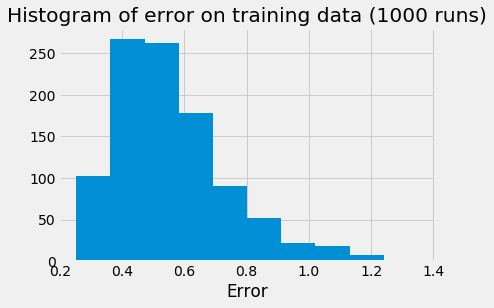

Text(0.5, 0, 'Error')

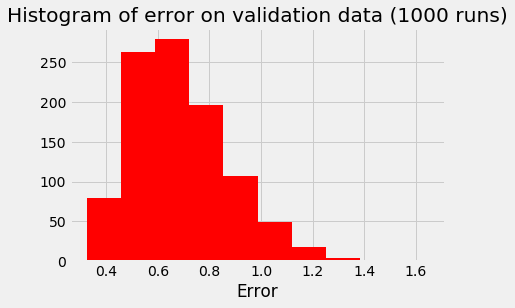

In [5]:
e_train = []
e_valid = []
for i in range(1000):
    m = data_tr.shape[0]
    n = data_tr.shape[1]

    W1 = torch.randn(4,12, requires_grad=True)
    W2 = torch.randn(12,3, requires_grad=True)
    b1 = torch.tensor(0.0, requires_grad=True)
    b2 = torch.tensor(0.0, requires_grad=True)

    num_epochs = 100
    lr = 0.01

    for epoch in range(num_epochs):
        W1.grad = None
        W2.grad = None
        b1.grad = None
        b2.grad = None
        logits = torch.relu(data_tr@W1 + b1) @ W2 + b2
        e = torch.nn.functional.cross_entropy(logits,targets_tr)
        e.backward()
        z1 = W1 - lr*W1.grad
        z2 = W2 - lr*W2.grad
        z3 = b1 - lr*b1.grad
        z4 = b2 - lr*b2.grad
        W1.data = z1
        W2.data = z2
        b1.data = z3
        b2.data = z4
    e_train.append(float(e))
    e_valid.append(float(torch.nn.functional.cross_entropy(torch.relu(data_va@W1 + b1) @ W2 + b2,targets_va)))

plt.hist(e_train, label="Error on training data")
plt.xlabel("Error")
plt.title("Histogram of error on training data (1000 runs)")
plt.show()
plt.hist(e_valid, label="Error on validation data",color="r")
plt.title("Histogram of error on validation data (1000 runs)")
plt.xlabel("Error")

In [6]:
print(np.mean(e_train))
print(np.std(e_train))

print(np.mean(e_valid))
print(np.std(e_valid))

0.5570685041844845
0.17913303028892055
0.6887497974932194
0.19066765793846668
